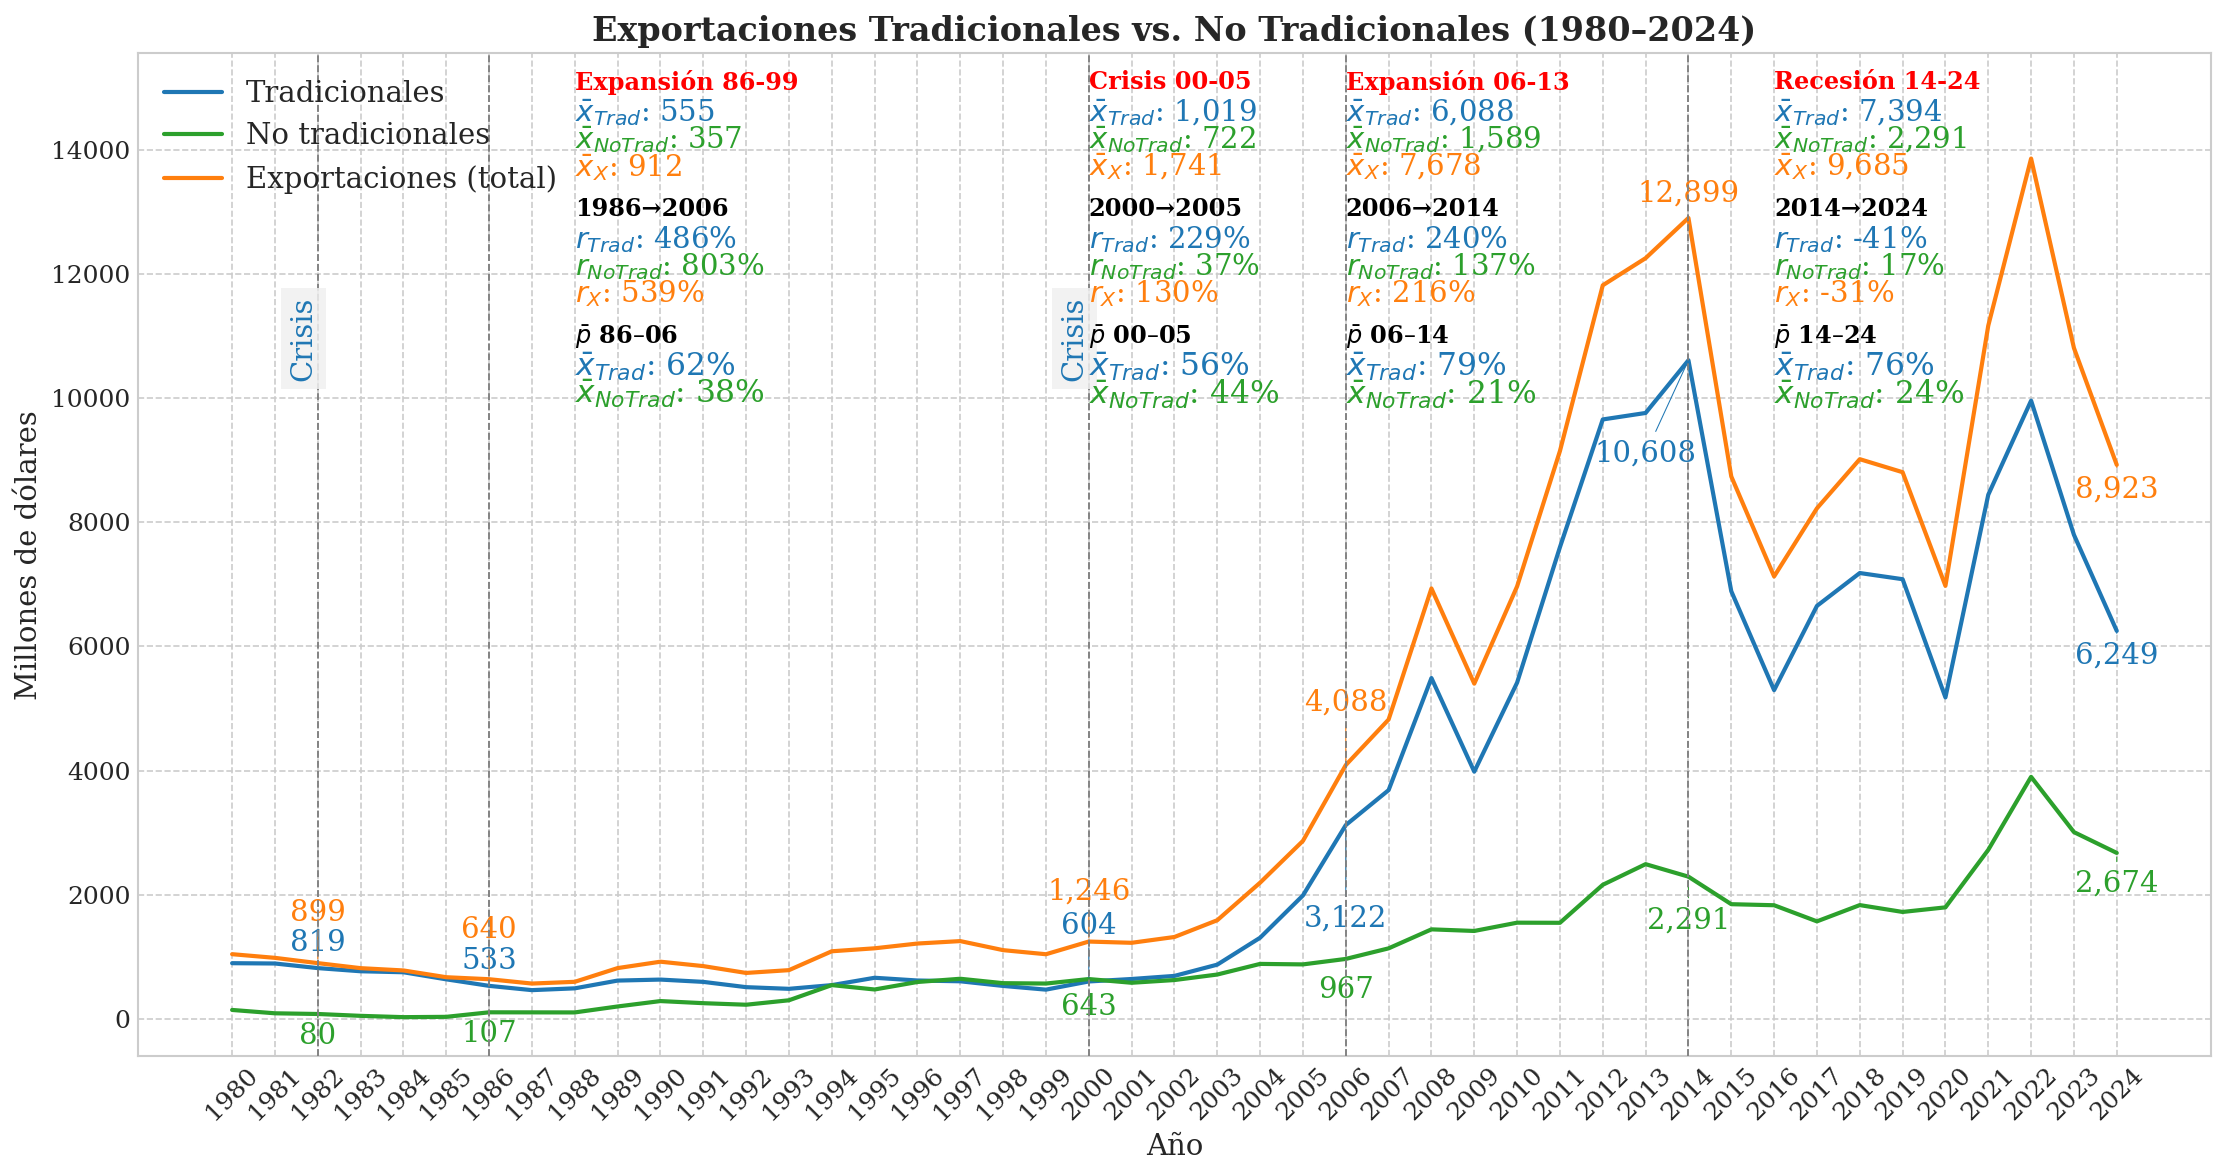

In [3]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os
from matplotlib.lines import Line2D
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi, add_participation_cycle_boxes
)

# ── 0.  Tramos de ciclo (consistentes con el resto de la tesis) ───────
CRISIS_82_85      = slice(1982, 1985)   # Crisis (neoliberal)
EXPANSION_86_99   = slice(1986, 1999)   # Expansión
CRISIS_00_05      = slice(2000, 2005)   # Crisis
ACUMULACION_06_13 = slice(2006, 2013)   # Acumulación
RECESION_14_24    = slice(2014, 2024)   # Recesión

periods = {
    "Expansión 86-99": EXPANSION_86_99,
    "Expansión 06-13": ACUMULACION_06_13,
    "Crisis 00-05": CRISIS_00_05,
    "Recesión 14-24":  RECESION_14_24,
}

# ── 1. Configuración general ─────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif', 'font.size': 12,
    'axes.titlesize': 16,   'axes.labelsize': 14,
    'grid.linestyle': '--', 'lines.linewidth': 2,
    'figure.dpi': 150,      'savefig.bbox': 'tight'
})

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql('SELECT * FROM exportaciones_tradicionales_no_tradicionales', conn)
            .set_index('año')
            .sort_index())
    df['exportaciones'] = df['tradicionales'] + df['no_tradicionales']

# ── 3. Estadísticas por ciclo ────────────────────────────────────────
cycle_stats = {
    name: df.loc[period].mean().to_dict()
    for name, period in periods.items()
}

# ── 4. Hitos, años clave, offsets ────────────────────────────────────
hitos_v = {
    1982: "Crisis", 1986: "Expansión", 2000: "Crisis",
    2006: "Expansión", 2014: "Recesión"
}
hitos_offset = {a: 0.8 for a in hitos_v}

medias_offset = {
    "Expansión 86-99": (1988, 1.05),
    "Crisis 00-05": (2000, 1.05),
    "Expansión 06-13": (2006, 1.05),
    "Recesión 14-24":  (2016, 1.05),
}

anot_years = [1982, 1986, 2000, 2006, 2014, 2024]
annotation_offsets = {
    'exportaciones':     {
        1982: (0,  800), 1986: (0,  800), 2000: (0,  800),
        2006: (0,  1000), 2014: (0,  400), 2024: (0,  -400),
    },
    'tradicionales':     {
        1982: (0,  400), 1986: (0,  400), 2000: (0,  900),
        2006: (0,  -1500), 2014: (-1,  -1500), 2024: (0,  -400),
    },
    'no_tradicionales':  {
        1982: (0, -350), 1986: (0, -350), 2000: (0, -450),
        2006: (0, -500), 2014: (0, -700), 2024: (0, -500),
    },
}

annotation_tasas_offsets = {
    "1986-2006": (1988, 0.91),
    "2000-2005": (2000, 0.91),
    "2006-2014": (2006, 0.91),
    "2014-2024": (2016, 0.91),
}

participation_offsets = {
    "1986-2006": (1988, 0.77),   
    "2000-2005": (2000, 0.77),
    "2006-2014": (2006, 0.77),
    "2014-2024": (2016, 0.77),
}

# ── 5. Gráfico ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(df.index, df['tradicionales'],
        label='Tradicionales',      color='#1f77b4')
ax.plot(df.index, df['no_tradicionales'],
        label='No tradicionales',   color='#2ca02c')
ax.plot(df.index, df['exportaciones'],
        label='Exportaciones (total)',      color='#ff7f0e')

# ── 6. Hitos ─────────────────────────────────────────────────────────
add_hitos(ax, df.index, hitos_v, hitos_offset, line_kwargs={'linewidth':0.9})

# ── 7. Anotaciones de medias, valores y tasas ────────────────────────
abbr_map = {'tradicionales': 'Trad', 'no_tradicionales': 'NoTrad', 'exportaciones': 'X'}
component_colors = {'tradicionales': '#1f77b4', 'no_tradicionales': '#2ca02c', 'exportaciones': '#ff7f0e'}

y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
cols = ['tradicionales', 'no_tradicionales', 'exportaciones']

add_cycle_means_multi(ax, cycle_stats, medias_offset,
                      abbr_map, component_colors, line_spacing)

add_year_value_annotations(ax, df, anot_years,
                           cols, annotation_offsets, component_colors, arrow_lw=0.5)

periodos = [(1986, 2006), (2000, 2005), (2006, 2014), (2014, 2024)]
add_period_growth_annotations_multi(ax, df, periodos,
    cols, annotation_tasas_offsets, component_colors, abbr_map)

add_participation_cycle_boxes(
    ax, df, periodos,
    ['tradicionales', 'no_tradicionales'], #columnas
    'exportaciones',
    participation_offsets,
    abbr_map=abbr_map,
    colors=component_colors
)

ax.set_ylim(-600, y_max + 1000)
# ── 8. Ajustes finales ───────────────────────────────────────────────
ax.set_title(f"Exportaciones Tradicionales vs. No Tradicionales ({df.index[0]}–{df.index[-1]})",
             fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de dólares")
ax.set_xticks(df.index[::max(1, len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "exportaciones_tradicionales_no_tradicionales.png"))
plt.show()
